In [1]:
import numpy as np
from skimage import data, color, feature
import skimage.data
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from skimage import transform
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

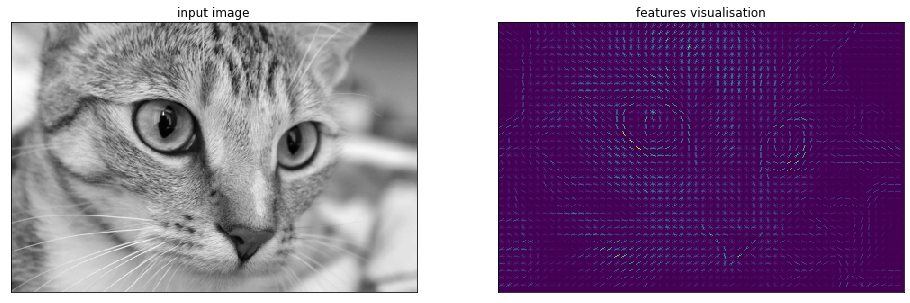

In [2]:
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(16, 8),subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')
ax[1].imshow(hog_vis)
ax[1].set_title('features visualisation');

In [3]:
faces = fetch_lfw_people()
posittive_patches = faces.images
posittive_patches.shape

(13233, 62, 47)

In [4]:
imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock',
              'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) 
          for name in  imgs_to_use]

In [5]:
def extract_patches(img, N, scale=1.0, patch_size= posittive_patches[0].shape):
    extract_patches_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extract_patches_size, max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size) for patch in patches])
    return patches

In [6]:
negative_pathes = np.vstack([extract_patches(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]])
negative_pathes.shape

(30000, 62, 47)

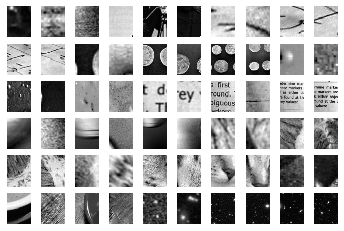

In [7]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_pathes[500 * i], cmap='gray')
    axi.axis('off')

In [8]:
x_train = np.array([feature.hog(im) for im in chain(negative_pathes, posittive_patches)])
y_train = np.zeros(x_train.shape[0])
y_train[:posittive_patches.shape[0]] = 1
x_train.shape

(43233, 1215)

In [9]:
cross_val_score(GaussianNB(), x_train, y_train, cv=3)

array([0.34334883, 0.57483866, 0.66733745])

In [10]:
grid = GridSearchCV(LinearSVC(max_iter=2000), {'C':[1., 2., 3., 4., 8.]})
grid.fit(x_train, y_train)
grid.best_score_

C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\sklearn\svm\base.py:92

0.6551245576295885

In [11]:
grid.best_params_

{'C': 1.0}

In [12]:
model = grid.best_estimator_
model.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [13]:
LinearSVC(C=4.0, class_weight=None, dual=True, 
          fit_intercept=True, intercept_scaling=1, loss='square_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2',
          random_state=None, tol=0.0001, verbose=0)

LinearSVC(C=4.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='square_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


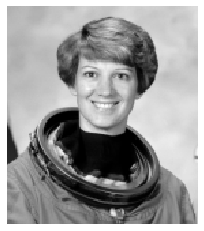

In [14]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [15]:
def sliding_window(img, patch_size=posittive_patches[0].shape, istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Nj, jstep):
            patch = img[i: i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [16]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(2303, 1215)

In [17]:
labels = model.predict(patches_hog)
labels.sum()

1106.0

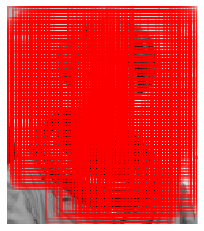

In [18]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = posittive_patches[0].shape
indices = np.array(indices)
for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j,i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='None'))